# 6.7 TransferLearning

### 导入utils中的辅助函数

In [1]:
from utils import *

## 读入猫狗数据

In [2]:
%ls ../dataset/CatDog
%ls ../dataset/CatDog/train
%ls ../dataset/data/CatDog/validation

train/  validation/
cats/  dogs/
ls: cannot access '../dataset/data/CatDog/validation': No such file or directory


In [3]:
batch_size = 32 # 指定batch_size 
IMSIZE = 128
data_dir = '../dataset/CatDog' # 指定图片路径

## 数据准备

In [4]:
# 测试集无需数据增强，将读入的图片resize后，转换成tensor
val_transform = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)), 
    transforms.ToTensor()
])

In [5]:
# 训练集进行数据增强
train_transform = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)), # Resize成规定尺寸
    transforms.RandomCrop(IMSIZE, padding=8), #随机裁剪
    transforms.RandomHorizontalFlip(), #水平翻转
    transforms.ToTensor()
])

In [6]:
# 准备dataset，使用torchvision.datasets.ImageFolder读入图片，指定变换形式
train_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_set = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'validation'), transform=val_transform)
# 准备dataloaer

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)  # 进行打乱
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4) 

torch.Size([32, 3, 128, 128])
torch.Size([32])


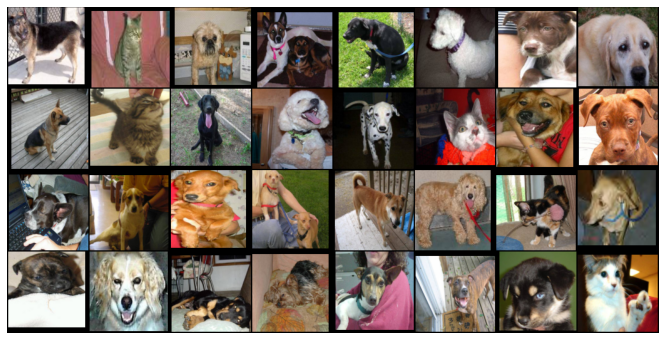

In [7]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 6))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

借助PyTorch内置的nn.Sequential类构建模型。

## ResNet34迁移模型
- 预训练

In [8]:
from torchvision.models import resnet34
### 如果下载的太慢，可以从矩池云直接copy模型文件过来
###!cp '/public/pytorch_models/resnet/old/resnet34-333f7ec4.pth' '/root/.cache/torch/hub/checkpoints/'
#resnet_model = resnet34.load_state_dict(torch.load("/public/pytorch_models/resnet/old/resnet34-333f7ec4.pth"))
resnet_model = torchvision.models.resnet34(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/zhoujing/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100.0%


In [9]:
from torchsummary import summary
## 需要预先下载，在终端输入 pip install torchsummary
resnet_model = resnet_model.cuda()
summary(resnet_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [10]:
lr = 1e-4
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
epochs = 5
history = train(resnet_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/5], time: 25.72s, loss: 0.1210, acc: 0.9520, val_loss: 0.0872, val_acc: 0.9671
Epoch [2/5], time: 25.51s, loss: 0.3196, acc: 0.8386, val_loss: 0.1142, val_acc: 0.9547
Epoch [3/5], time: 25.59s, loss: 0.0876, acc: 0.9653, val_loss: 0.1062, val_acc: 0.9571
Epoch [4/5], time: 25.49s, loss: 0.0687, acc: 0.9737, val_loss: 0.1020, val_acc: 0.9608
Epoch [5/5], time: 25.52s, loss: 0.0583, acc: 0.9772, val_loss: 0.0828, val_acc: 0.9708


## ResNet34迁移模型
- 另一种模式

In [11]:
resnet_model2 = torchvision.models.resnet34(pretrained=True)
for para in resnet_model2.parameters():
    para.required_grad = False
resnet_model2.fc = nn.Linear(resnet_model2.fc.in_features, 2)

In [12]:
resnet_model2 = resnet_model2.cuda()

In [13]:
lr = 1e-4

# filter 函数将模型中属性 requires_grad = True 的参数选出来
params_train = filter(lambda p: p.requires_grad, resnet_model2.parameters())
optimizer = torch.optim.Adam(params_train, lr=lr)

In [ ]:
epochs = 5
history = train(resnet_model2, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/5], time: 25.82s, loss: 0.1244, acc: 0.9501, val_loss: 0.0815, val_acc: 0.9666
Epoch [2/5], time: 25.60s, loss: 0.1279, acc: 0.9479, val_loss: 0.1341, val_acc: 0.9554
Epoch [3/5], time: 25.49s, loss: 0.0800, acc: 0.9688, val_loss: 0.0794, val_acc: 0.9706
Epoch [4/5], time: 25.48s, loss: 0.0607, acc: 0.9777, val_loss: 0.0866, val_acc: 0.9641
